In [1]:
import sys
rex_path = "/home/r2ci/rex"
if rex_path not in sys.path:
    sys.path.append(rex_path)
print(sys.path)

['/home/r2ci/rex/notebooks', '/home/r2ci/rex', '/home/r2ci/supergraph', '/home/r2ci/sbx', '/home/r2ci/trajax', '', '/home/r2ci/catkin_ws/devel/lib/python3/dist-packages', '/home/r2ci/interbotix_ws/devel/lib/python3/dist-packages', '/opt/ros/noetic/lib/python3/dist-packages', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '/home/r2ci/.cache/pypoetry/virtualenvs/rex-lib-fAzIlxw_-py3.8/lib/python3.8/site-packages']


In [2]:
from typing import Union
import time
import os
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpy as onp
import jax.random as rnd
from jax.tree_util import tree_map

import rex.utils as utils
from rex.utils import timer, make_put_output_on_device
import rex.open_colors as oc
from rex.wrappers import GymWrapper, AutoResetWrapper, VecGymWrapper
from rex.proto import log_pb2
from rex.node import Node
from rex.constants import LATEST, BUFFER, SILENT, DEBUG, INFO, WARN, SYNC, ASYNC, REAL_TIME, FAST_AS_POSSIBLE, FREQUENCY, PHASE, SIMULATED, WALL_CLOCK
from rex.distributions import Gaussian, GMM
from rex.base import GraphState, StepState

utils.set_log_level(WARN)

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
# gpu_device = jax.devices('gpu')[0]
cpu_device = jax.devices('cpu')[0]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
import experiments as exp
import stable_baselines3 as sb3
import envs.double_pendulum as dpend

# Environment
ENV = "double_pendulum"
DIST_FILE = f"21eps_pretrained_sbx_sac_gmms_2comps.pkl"
JITTER = BUFFER
SCHEDULING = PHASE
MAX_STEPS = 5*80
WIN_ACTION = 2
WIN_OBS = 3
BLOCKING = True
ADVANCE = False
ENV_FN = dpend.ode.build_double_pendulum
ENV_CLS = dpend.env.DoublePendulumEnv
CLOCK = SIMULATED
RTF = REAL_TIME
RATE_ESTIMATOR = 40
RATES = dict(world=150, agent=80, actuator=80, sensor=80, render=20)
DELAY_FN = lambda d: d.high*0.75
USE_DELAYS = True   # todo: TOGGLE WITH/WITHOUT DELAYS HERE

# Load models
MODEL_CLS = sb3.SAC  # sbx.SAC
MODEL_MODULE = dpend.models
MODEL_PRELOAD = "sb_sac_model"

# Training
SEED = 0
NUM_ENVS = 10
SAVE_FREQ = 40_000
NSTEPS = 200_000
NUM_EVAL_PRE = 1
NUM_EVAL_POST = 20
HYPERPARAMS = {"learning_rate": 0.01}
CONTINUE = True

# Record settings
RECORD_SETTINGS = {"agent": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "world": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "actuator": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "sensor": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "render": dict(node=True, outputs=False, rngs=True, states=True, params=True, step_states=True)}

In [4]:
# Load distributions
delays_sim = exp.load_distributions(DIST_FILE)

# Prepare environment
env = exp.make_env(delays_sim, DELAY_FN, RATES, blocking=BLOCKING, advance=ADVANCE, win_action=WIN_ACTION, win_obs=WIN_OBS,
                   scheduling=SCHEDULING, jitter=JITTER,
                   env_fn=ENV_FN, env_cls=ENV_CLS, name=ENV, eval_env=True, clock=CLOCK, real_time_factor=RTF,
                   max_steps=MAX_STEPS, use_delays=USE_DELAYS)
gym_env = GymWrapper(env)

# Warmup nodes
env.graph.init = jax.jit(env.graph.init, static_argnames=["order"], device=cpu_device)
with timer(f"warmup[graph.init]", log_level=100):
    graph_state = env.graph.init(jax.random.PRNGKey(0), order=("agent", "world"))
for node in env.graph.nodes_and_root.values():
    if node.name == "render":
        continue
    node.step = jax.jit(node.step, device=cpu_device)
    with timer(f"warmup[{node.name}]", log_level=100):
        _, _ = node.step(graph_state.nodes[node.name])
    with timer(f"eval[{node.name}]", log_level=100):
        _, _ = node.step(graph_state.nodes[node.name])
    
# Load model
model = exp.load_model(MODEL_PRELOAD, MODEL_CLS, env=gym_env, seed=SEED, module=MODEL_MODULE)

# Make policy
policy = exp.make_policy(model)

# Evaluate model
record_pre = exp.eval_env(gym_env, policy, n_eval_episodes=NUM_EVAL_PRE, verbose=True, seed=SEED, record_settings=RECORD_SETTINGS)

[25785][MainThread               ][tracer              ][warmup[graph.init]  ] Elapsed: 0.5008878707885742
[25785][MainThread               ][tracer              ][warmup[world]       ] Elapsed: 0.7251298427581787
[25785][MainThread               ][tracer              ][eval[world]         ] Elapsed: 0.00043487548828125
[25785][MainThread               ][tracer              ][warmup[actuator]    ] Elapsed: 0.029474735260009766
[25785][MainThread               ][tracer              ][eval[actuator]      ] Elapsed: 0.00012421607971191406
[25785][MainThread               ][tracer              ][warmup[sensor]      ] Elapsed: 0.40518665313720703
[25785][MainThread               ][tracer              ][eval[sensor]        ] Elapsed: 0.0003020763397216797
[25785][MainThread               ][tracer              ][warmup[agent]       ] Elapsed: 0.03218364715576172
[25785][MainThread               ][tracer              ][eval[agent]         ] Elapsed: 0.00020647048950195312
Wrapping the env with

/home/r2ci/.cache/pypoetry/virtualenvs/rex-lib-fAzIlxw_-py3.8/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


double_pendulum_ode_eval_buffer_phase_awin2_owin3_blocking_noadvance | steps=400 | fps= 54.5574 | reward=185.49609375
double_pendulum_ode_eval_buffer_phase_awin2_owin3_blocking_noadvance | steps=400 | fps= 70.4588 | reward=194.00759887695312
double_pendulum_ode_eval_buffer_phase_awin2_owin3_blocking_noadvance | steps=400 | fps= 70.3995 | reward=208.73890686035156
double_pendulum_ode_eval_buffer_phase_awin2_owin3_blocking_noadvance | mean reward=196.08 +/- 9.60


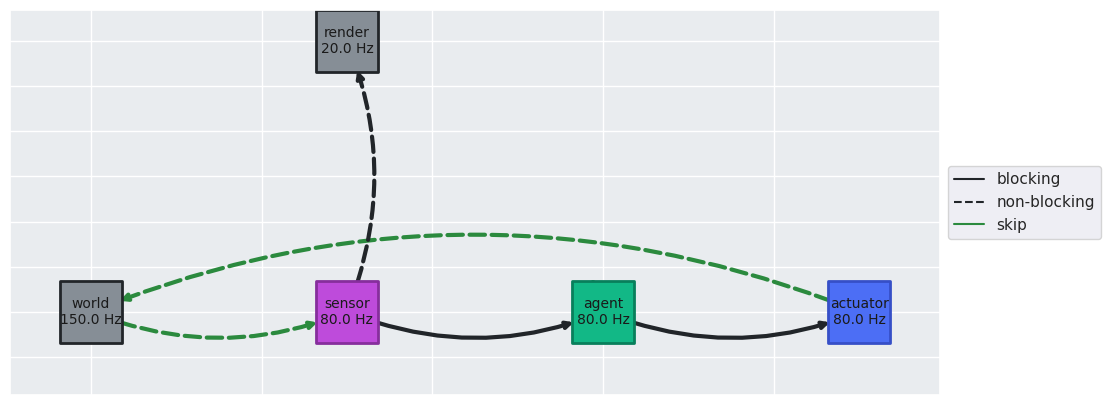

In [5]:
# Plot
fig_gr, _ = exp.show_graph(record_pre.episode[-1])

In [6]:
# Fit delays
data, info, est, dist = exp.make_delay_distributions(record_pre, num_steps=500, num_components=8, step_size=0.05, seed=0)

actuator.input(action) | Time taken: 0.79 seconds.
agent.input(last_action) | Time taken: 0.70 seconds.
agent.input(state) | Time taken: 0.82 seconds.
render.input(sensor) | Time taken: 0.77 seconds.
sensor.input(world) | Skip because close to deterministic | mean(data)=0.0 | std(data)=0.0.
world.input(actuator) | Time taken: 0.72 seconds.
actuator | Time taken: 0.75 seconds.
agent | Time taken: 0.75 seconds.
render | Time taken: 0.69 seconds.
sensor | Time taken: 0.69 seconds.
world | Skip because close to deterministic | mean(data)=0.0 | std(data)=0.0.


In [7]:
%matplotlib agg

# Plot gmm training
from rex.open_colors import ecolor, fcolor
est_agent = est["step"]["agent"]
fig_agent, ax_agent = plt.subplots()
ax_agent.set(title="GMM fit on computation delay (Agent)", xlabel="delay (s)", ylabel="density")
est_agent.plot_hist(ax=ax_agent, edgecolor=ecolor.computation, facecolor=fcolor.computation, plot_dist=False)

# Animate
from IPython.display import HTML
ani = est_agent.animate_training(fig=fig_agent, ax=ax_agent, num_frames=50, edgecolor=ecolor.computation, facecolor=fcolor.computation)
HTML(ani.to_html5_video()) 

{'actuator': {'action': None},
 'agent': {'state': None},
 'render': {'sensor': None},
 'sensor': {}}

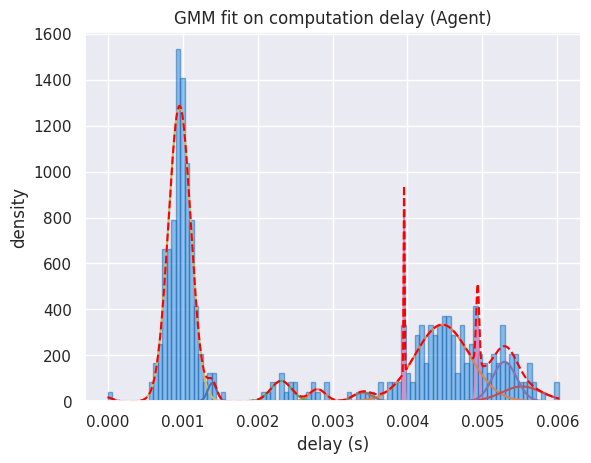

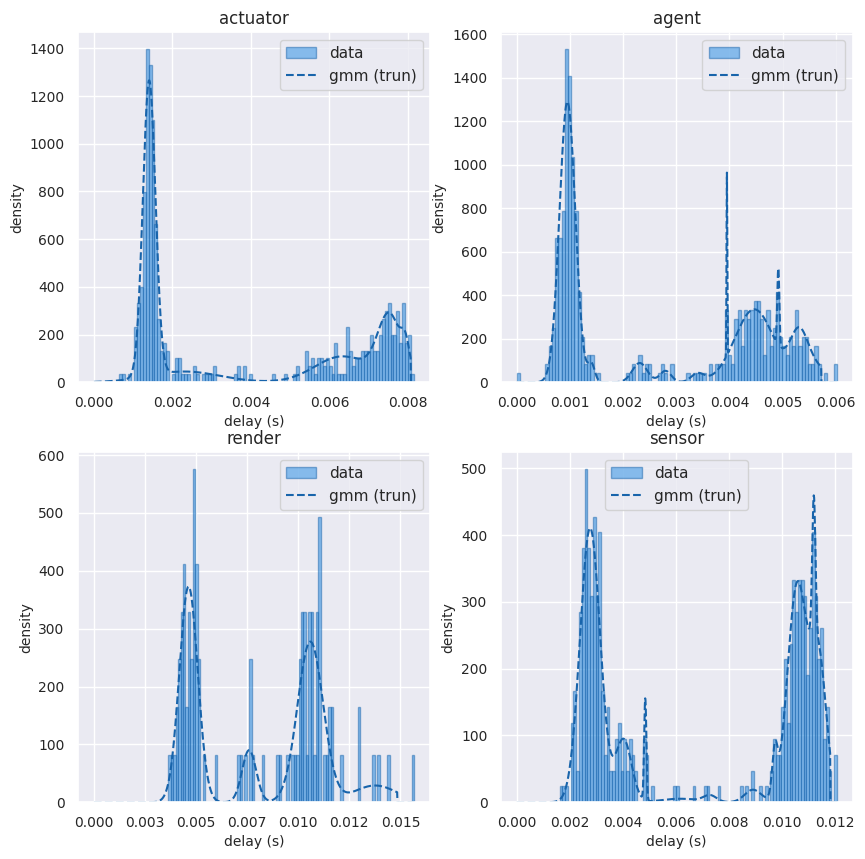

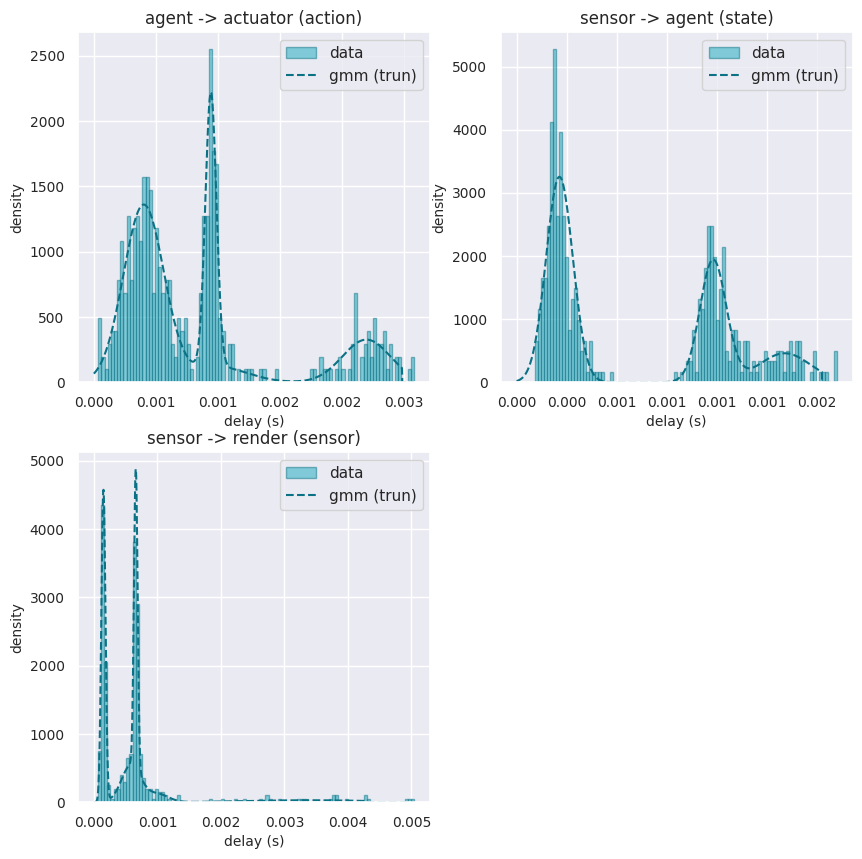

In [8]:
%matplotlib inline
# Pop world from
[_d["inputs"]["agent"].pop("last_action", None) for _d in [data, info, est, dist]]
[_d["inputs"]["sensor"].pop("world", None) for _d in [data, info, est, dist]]
[_d["inputs"].pop("world", None) for _d in [data, info, est, dist]]
[_d["step"].pop("world", None) for _d in [data, info, est, dist]]

# Split
est_inputs, est_step = est["inputs"], est["step"]
data_inputs, data_step = data["inputs"], data["step"]
info_inputs, info_step = info["inputs"], info["step"]
dist_inputs, dist_step = dist["inputs"], dist["step"]

# Plot gmm
from matplotlib.ticker import FormatStrFormatter
import numpy as onp
def plot_gmm(ax, dist, delays, i, edgecolor):
    x = onp.linspace(0, onp.max(delays), 1000)
    y = dist.pdf(x)
    if hasattr(i, "cls"):
        ax.plot(x, y, label="gmm (trun)", color=edgecolor, linestyle="--")
        ax.set_title(f"{i.name}")
    else:
        node_info, input_info = i
        ax.plot(x, y, label="gmm (trun)", color=edgecolor, linestyle="--")
        ax.set_title(f"{input_info.output} -> {node_info.name} ({input_info.name})")
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlabel('delay (s)', fontsize=10)
    ax.set_ylabel('density', fontsize=10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.legend()

# Plot distributions
from rex.plot import get_subplots
fig_step, axes_step = get_subplots(est_step, figsize=(10, 10), sharex=False, sharey=False, major="row")
fig_inputs, axes_inputs = get_subplots(est_inputs, figsize=(10, 10), sharex=False, sharey=False, major="row")

# Plot measured delays
from rex.open_colors import ecolor, fcolor
jax.tree_map(lambda ax, e: e.plot_hist(ax=ax, edgecolor=ecolor.computation, facecolor=fcolor.computation, plot_dist=False), axes_step, est_step)
jax.tree_map(lambda ax, e: e.plot_hist(ax=ax, edgecolor=ecolor.communication, facecolor=fcolor.communication, plot_dist=False), axes_inputs, est_inputs)

# Plot gmm
from functools import partial
jax.tree_map(partial(plot_gmm, edgecolor=ecolor.computation), axes_step, dist_step, data_step, info_step)
jax.tree_map(partial(plot_gmm, edgecolor=ecolor.communication), axes_inputs, dist_inputs, data_inputs, info_inputs)

In [9]:
# Trace & compile environment
SUPERGRAPH_MODE = "MCS"
cenv = exp.make_compiled_env(env, record_pre.episode[-1], max_steps=MAX_STEPS, eval_env=False, supergraph_mode=SUPERGRAPH_MODE, progress_bar=True)

Growing supergraph: 100%|██████████| 401/401 [00:00<00:00, 1220.62it/s, 1/1 graphs, 1951/1951 matched (81.09% efficiency, 6 nodes)]


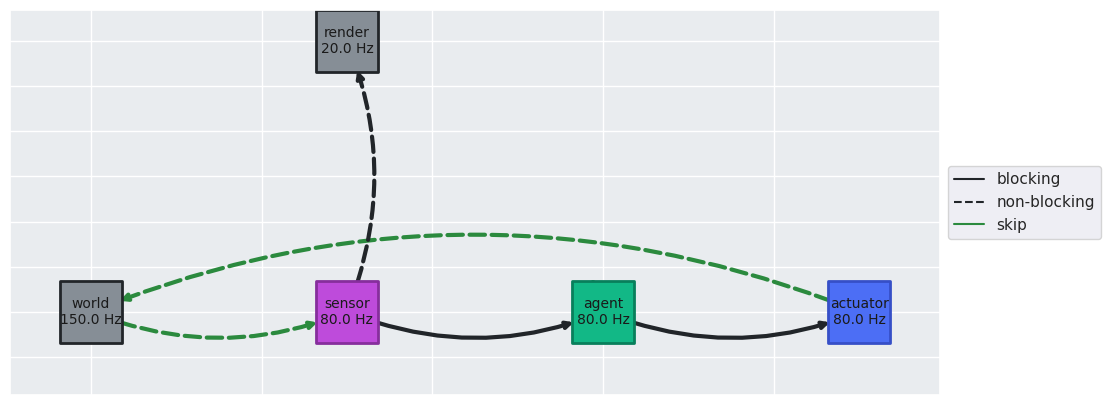

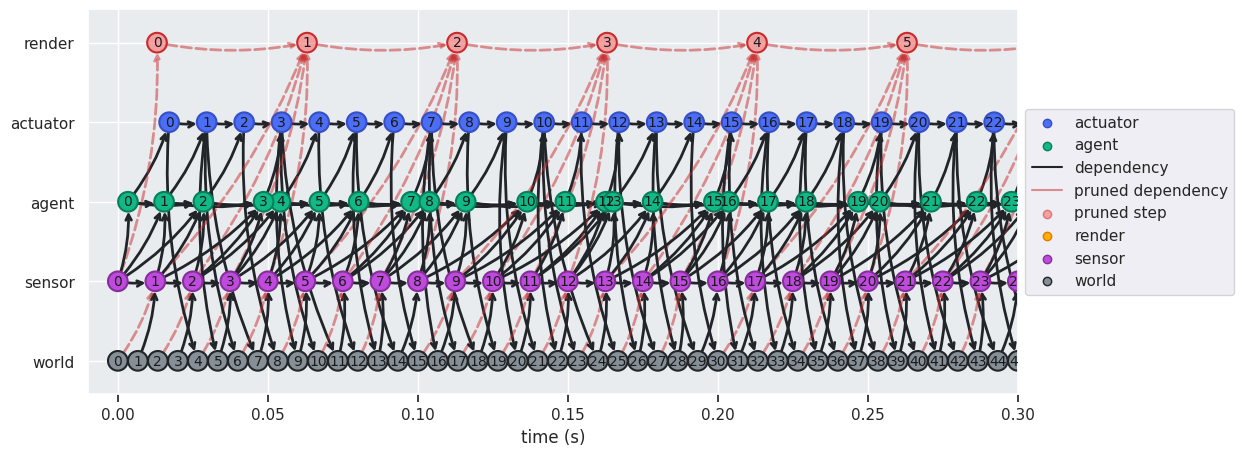

In [10]:
# Create computation graph
from rex.supergraph import create_graph
G = create_graph(record_pre.episode[-1])

# Plot
fig_gr, _ = exp.show_graph(record_pre.episode[-1])
fig_cg, _ = exp.show_computation_graph(G, cenv.graph.S, "agent", "computation", xmax=0.35)
# fig_ct, _ = exp.show_computation_graph(G, cenv.graph.S, "agent", "topological", xmax=0.35)
# fig_cd, _ = exp.show_computation_graph(G, cenv.graph.S, "agent", "depth", xmax=0.35, supergraph_mode=SUPERGRAPH_MODE)
# fig_com, _ = exp.show_communication(record_pre.episode[-1])
# fig_grp, _ = exp.show_grouped(record_pre.episode[-1].node[-1], "state")

In [11]:
rw = exp.RolloutWrapper(cenv)

nenvs = 7000
seed = jax.random.PRNGKey(0)
rng = jax.random.split(seed, num=nenvs)
for i in range(5):
    seed = jax.random.PRNGKey(i)
    rng = jax.random.split(seed, num=nenvs)
    timer = utils.timer(f"{i=}", log_level=0)
    with timer:
        res = rw.batch_rollout(rng)
    fps = env.max_steps * nenvs / timer.duration
    print(f"[{timer.name}] time={timer.duration} sec | fps={fps:.0f} steps/sec")

[i=0] time=14.695317029953003 sec | fps=190537 steps/sec
[i=1] time=5.155101537704468 sec | fps=543151 steps/sec
[i=2] time=5.060177803039551 sec | fps=553340 steps/sec
[i=3] time=5.042431354522705 sec | fps=555288 steps/sec
[i=4] time=5.2026190757751465 sec | fps=538190 steps/sec


In [12]:
# Prepare data
data = exp.RecordHelper(record_pre)

# Build estimator
from estimator import build_estimator
record, nodes, excludes_inputs = build_estimator(record_pre, rate=RATE_ESTIMATOR, data=data)

In [13]:
# Trace
from rex.supergraph import get_network_record
SUPERGRAPH_MODE = "MCS"
record_network, S, S_init_to_S, Gs, Gs_monomorphism = get_network_record(record.episode, "estimator",
                                                                         supergraph_mode=SUPERGRAPH_MODE,
                                                                         excludes_inputs=excludes_inputs,
                                                                         progress_bar=True)

Growing supergraph: 100%|██████████| 202/202 [00:00<00:00, 1197.11it/s, 1/1 graphs, 1756/1756 matched (96.59% efficiency, 9 nodes)]


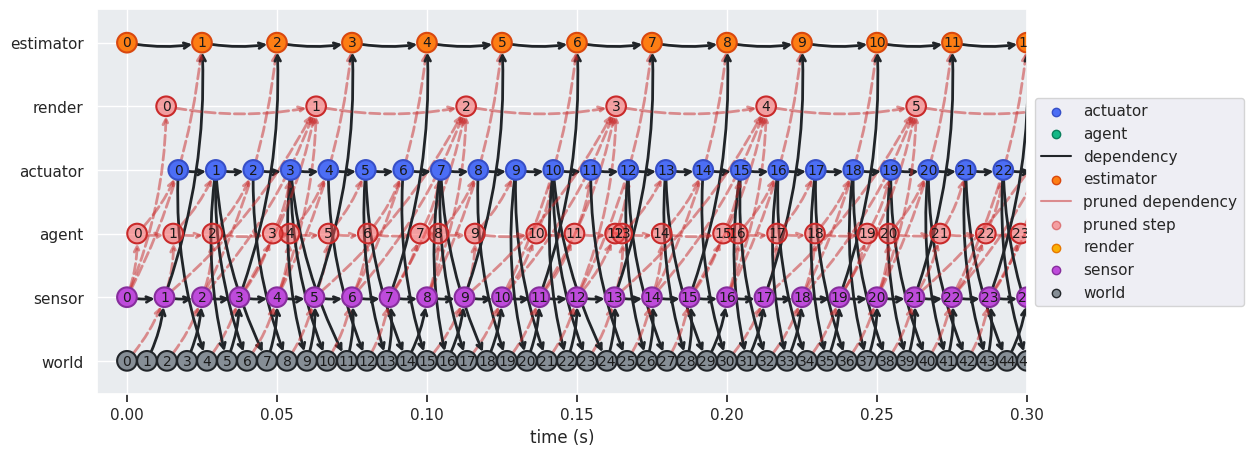

In [14]:
fig_cd, _ = exp.show_computation_graph(Gs[0], S, "estimator", xmax=0.35, supergraph_mode="MCS")

In [ ]:
# Add Estimator node to record
import flax.struct as struct

@struct.dataclass
class Loss:
    loss: Union[float, jax.typing.ArrayLike]
    rloss: Union[float, jax.typing.ArrayLike]
    dloss: Union[float, jax.typing.ArrayLike]


alpha_dloss = nodes["world"].default_state(jax.random.PRNGKey(0)).replace(th=0.e0, th2=0.e0, thdot=0.e-2, thdot2=0.e-3)

def loss_fn(graph_state):
    """Get loss."""
    # Calculate reconstruction loss
    rloss_sensor = graph_state.nodes["sensor"].state.cum_loss
    rloss = rloss_sensor.cos_th + rloss_sensor.sin_th + rloss_sensor.sin_th2 + rloss_sensor.cos_th2
    # rloss += 1e-1*rloss_sensor.thdot
    rloss += 1e-3*rloss_sensor.thdot + 1e-3*rloss_sensor.thdot2

    # Calculate transition loss
    fwd_state = graph_state.nodes["world"].state
    # NOTE: mode="clip" disables negative indexing.
    eps, step = graph_state.eps, graph_state.step
    ws = graph_state.nodes["estimator"].params.world_states
    est_state = jax.tree_map(lambda x: jax.lax.dynamic_slice(x, [eps, step+1] + [0 * s for s in x.shape[2:]], [1, 1] + list(x.shape[2:]))[0, 0], ws)
    dloss = jax.tree_util.tree_map(lambda x, y: (x - y) ** 2, est_state, fwd_state)
    dloss = jax.tree_util.tree_map(lambda e, a: a*e, dloss, alpha_dloss)
    dloss = jax.tree_util.tree_reduce(lambda acc, l: acc + jnp.sum(l), dloss, 0.)
    loss = rloss + dloss
    output = Loss(loss=loss, rloss=rloss, dloss=dloss)
    return output

# Compile env
from estimator import EstimatorEnv
from rex.compiled import CompiledGraph

graph = CompiledGraph(nodes, nodes["estimator"], S)
cenv = EstimatorEnv(graph, loss_fn=loss_fn)

# Get initial graph_state
from estimator import init_graph_state

init_gs, outputs = init_graph_state(cenv, nodes, record_network, S, Gs, Gs_monomorphism, data)

# Define initial params
p_tree = jax.tree_util.tree_map(lambda x: None, nodes["world"].default_params(jax.random.PRNGKey(0)))
# p_world = p_tree.replace(mass=0.3, mass2=0.3, K=1.0, J=0.02)
p_world = jax.tree_util.tree_map(lambda x: x * 1.2, p_tree.replace(# J=0.037,
                                                                   # J2=0.000111608131930852,
                                                                   mass=0.18,
                                                                   mass2=0.0691843934004535,
                                                                   # length=0.1,
                                                                   # length2=0.1,
                                                                   b=0.975872107940422,
                                                                   # b2=1.07098956449896e-05,
                                                                   # c=0.06,
                                                                   # c2=0.0185223578523340,
                                                                   K=1.09724557347983,
                                                                   ))
initial_params = {"estimator": init_gs.nodes["estimator"].params,
                  "world": p_world}

# Define prior
def make_prior_fn(guess, multiplier):
    def prior_fn(params):
        loss = jax.tree_util.tree_map(lambda x: None, params)
        if params.get("world", None) is not None:
            wloss = jax.tree_util.tree_map(lambda x, g: 1/(multiplier*(x/g)), params["world"], guess)
            loss["world"] = wloss
        return loss
    return prior_fn

guess = nodes["world"].default_params(jax.random.PRNGKey(0))
prior_fn = make_prior_fn(guess, multiplier=10000)

import optax
optimizer = optax.adam(learning_rate=5e-2)

# Define callbacks
from estimator.callback import LogCallback, StateFitCallback, ParamFitCallback
targets = nodes["world"].default_params(jax.random.PRNGKey(0))
callbacks = {"log": LogCallback(visualize=False),
             "state_fit": StateFitCallback(visualize=False),
             "param_fit": ParamFitCallback(targets=targets, visualize=False)}

# Optimize
from estimator import fit
metrics, opt_params, opt_state, opt_gs = fit(cenv, initial_params, optimizer, init_gs, outputs,
                                             # num_steps=10, num_batches=50, lr=1e-2 works, 1e-3 thdot.
                                             prior_fn=prior_fn, num_batches=50, num_steps=5, num_training_steps=10_000,
                                             num_training_steps_per_epoch=200, callbacks=callbacks)
# Print results
print(jax.tree_util.tree_map(lambda x, y: jnp.stack([x, y], axis=0), opt_params["world"], nodes["world"].default_params(jax.random.PRNGKey(0))))

[42049][MainThread               ][rex                 ][rex                 ] graph_state should be provided per default.: (fun=estimator.init_graph_state at line 343).


In [ ]:
%matplotlib agg

# Create animation
from IPython.display import HTML
ani_duration = 15.0
num_frames = len(callbacks["log"]._frames)
interval = int(1e3*ani_duration / num_frames)

# Loss animation
ani = callbacks["log"].get_animation(interval=interval)
HTML(ani.to_html5_video())

In [ ]:
%matplotlib agg

# State fitting animation
ani = callbacks["state_fit"].get_animation(interval=interval)
HTML(ani.to_html5_video())

In [ ]:
%matplotlib agg
# Parameter fitting animation
ani = callbacks["param_fit"].get_animation(interval=interval)
HTML(ani.to_html5_video())